In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import hydroeval as he

from CompressedSensingInterpolator import CompresedSensingInterpolator
from InterpolateHelperFunctions import *

site_names_list = ['BEN', 'BLI', 'BSL', 'CLE', 'CRB', 'DAI', 'DFF', 'DFL', 'DFM', 'DFU', 'HCL', 'HCN', 'HCS', 'IND', 'LAK', 'LDF', 'MIT', 'NEB', 'PBC', 'SBL', 'SFL', 'SHE', 'SOL', 'STR', 'TCU', 'TIE', 'WAN']
all_pressure_df = pd.read_csv("all_pressure.csv")

0.20703391759617573
0.4274214038325243


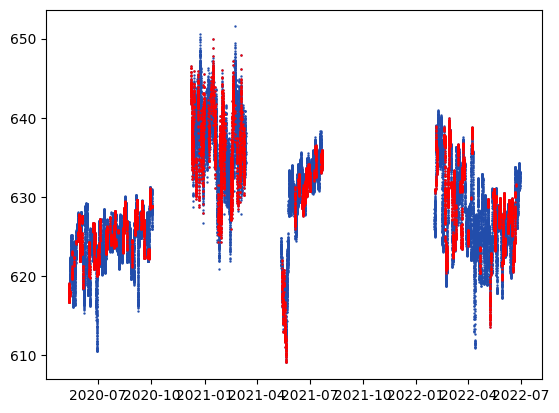

In [16]:
site_names_list = ['BEN', 'BLI', 'BSL', 'CLE', 'CRB', 'DAI', 'DFF', 'DFL', 'DFM', 'DFU', 'HCL', 'HCN', 'HCS', 'IND', 'LAK', 'LDF', 'MIT', 'NEB', 'PBC', 'SBL', 'SFL', 'SHE', 'SOL', 'STR', 'TCU', 'TIE', 'WAN']
all_pressure_df = pd.read_csv("all_pressure.csv")
site_id = "BEN"
site_df = pd.DataFrame()
site_df[["datetime","pressure_hobo"]] = all_pressure_df[["datetime",site_id]]
site_df['datetime'] = pd.to_datetime(site_df['datetime'], format='%Y-%m-%d %H:%M:%S')
site_df = site_df[site_df['pressure_hobo'].notna()]
all_days = pd.date_range(site_df['datetime'].min(), site_df['datetime'].max(), freq='15min')
all_days = pd.DataFrame(all_days, columns=["datetime"])
site_df = all_days.merge(site_df, on='datetime', how='left')

#generating a test dataframe from our actual data. This function generate randomly indexed sequences of nas of random lengths
test_df = get_test_df(site_df)

In [43]:
down_sample_list = [10,15,20,30,40,50]
mv_avg_width_list = [1,2,3,4,5,6,7,8,9,10,15,20,30,40,50,75,100,150,200]

In [ ]:
metrics_list = []
#iterate through each site
for site_id in site_names_list:
    print(f"Working on site: {site_id}")

    try:
        
        site_df[["datetime","pressure_hobo"]] = all_pressure_df[["datetime",site_id]]
        site_df['datetime'] = pd.to_datetime(site_df['datetime'], format='%Y-%m-%d %H:%M:%S')
        site_df = site_df[site_df['pressure_hobo'].notna()]
        all_days = pd.date_range(site_df['datetime'].min(), site_df['datetime'].max(), freq='15min')
        all_days = pd.DataFrame(all_days, columns=["datetime"])
        site_df = all_days.merge(site_df, on='datetime', how='left')

        #generating a test dataframe from our actual data. This function generate randomly indexed sequences of nas of random lengths
        test_df = get_test_df(site_df)

        #iterate through different potential down sample values
        for down_sample_value in down_sample_list:

            sparse_joined_test_df = down_sample_and_interpolate_once(test_df,all_days,down_sample_value,'pressure_hobo')
            
            #iterate through different potential moving average window widths
            for width_value in mv_avg_width_list:
                filled_test_df = sparse_joined_test_df
                filled_test_df["pressure_combined_filled"] = filled_test_df["pressure_combined"].rolling(min_periods=1, center=True, window=width_value).mean()

                my_nse = he.evaluator(he.nse, filled_test_df["pressure_combined_filled"], filled_test_df["pressure_hobo"])
                my_pbias = he.evaluator(he.pbias, filled_test_df["pressure_combined_filled"], filled_test_df["pressure_hobo"])
                my_rmse = he.evaluator(he.rmse, filled_test_df["pressure_combined_filled"], filled_test_df["pressure_hobo"])
                
                #add metrics and identifiers to a list of dictionaries
                metrics_dict = (site_id,down_sample_value, width_value, my_nse, my_pbias, my_rmse)
                metrics_list.append(metrics_dict)

    except:
        print(f"Site: {site_id} did not work")

#transform metrics list into dataframe
metrics_df = pd.DataFrame(metrics_list, columns=["site","down_sampled_to", "mv_avg_width","nse","pbias","rmse"])
metrics_df

(array([[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 1., 0.]]),
 array([0.3672499 , 0.43051836, 0.49378682, 0.55705527, 0.62032373,
        0.68359219, 0.74686065, 0.81012911, 0.87339756, 0.93666602,
        0.99993448]),
 <a list of 1650 BarContainer objects>)

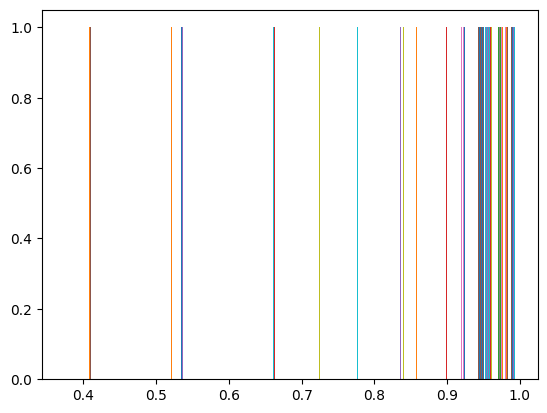

In [55]:
#metrics_df

plt.hist(x=metrics_df["nse"])

In [89]:
#fixing type for the metrics columns
metrics_df['nse'] = pd.to_numeric(metrics_df['nse'].str[0])
metrics_df['pbias'] = pd.to_numeric(metrics_df['pbias'].str[0])
metrics_df['rmse'] = pd.to_numeric(metrics_df['rmse'].str[0])

#the closer to 0 the better for percent bias, so taking the absolute value and then finding the minimum works here
metrics_df['pbias_abs'] = metrics_df['pbias'].abs()

In [106]:
#making a dataframe for each metric that shows which parameters resulted in the best score for each site
nse_maxs_df = metrics_df.loc[metrics_df.groupby('site')['nse'].idxmax().values]
pbias_mins_df = metrics_df.loc[metrics_df.groupby('site')['pbias_abs'].idxmin().values]
rmse_mins_df = metrics_df.loc[metrics_df.groupby('site')['rmse'].idxmin().values]


In [107]:
nse_maxs_df

,site,down_sampled_to,mv_avg_width,nse,pbias,rmse,pbias_abs
44,BEN,40,5,0.993067,0.000031,0.533587,0.000031
99,BLI,30,5,0.999667,-0.000152,0.101351,0.000152
176,BSL,40,5,0.999920,-0.000027,0.129575,0.000027
231,CLE,30,5,0.999708,-0.000059,0.146141,0.000059
319,CRB,50,5,0.998907,-0.000008,0.248881,0.000008
385,DAI,50,5,0.999001,-0.000733,1.516674,0.000733
429,DFF,30,5,0.999374,0.000012,0.158190,0.000012
484,DFL,20,5,0.999474,-0.000068,0.124234,0.000068
539,DFM,15,5,0.997896,0.000006,0.242264,0.000006
638,DFU,40,5,0.996873,0.000004,0.133964,0.000004


In [105]:
rmse_mins_df

,site,down_sampled_to,mv_avg_width,nse,pbias,rmse,pbias_abs
44,BEN,40,5,0.993067,0.000031,0.533587,0.000031
99,BLI,30,5,0.999667,-0.000152,0.101351,0.000152
176,BSL,40,5,0.999920,-0.000027,0.129575,0.000027
231,CLE,30,5,0.999708,-0.000059,0.146141,0.000059
319,CRB,50,5,0.998907,-0.000008,0.248881,0.000008
385,DAI,50,5,0.999001,-0.000733,1.516674,0.000733
429,DFF,30,5,0.999374,0.000012,0.158190,0.000012
484,DFL,20,5,0.999474,-0.000068,0.124234,0.000068
539,DFM,15,5,0.997896,0.000006,0.242264,0.000006
638,DFU,40,5,0.996873,0.000004,0.133964,0.000004


In [ ]:
pbias_mins_df

     site  down_sampled_to  mv_avg_width       nse     pbias      rmse  \
59    BEN               50            30  0.989880 -0.000002  0.644680   
103   BLI               30            30  0.997057  0.000025  0.301428   
143   BSL               15             5  0.999907  0.000004  0.139874   
209   CLE               15             5  0.999706 -0.000026  0.146694   
308   CRB               40             5  0.998882 -0.000002  0.251742   
370   DAI               30            75  0.983455 -0.000574  6.170721   
429   DFF               30             5  0.999374  0.000012  0.158190   
506   DFL               40             5  0.999461 -0.000027  0.125652   
539   DFM               15             5  0.997896  0.000006  0.242264   
638   DFU               40             5  0.996873  0.000004  0.133964   
682   HCL               20             5  0.968453 -0.000067  0.238953   
776   HCN               40            50  0.951366  0.000019  0.559814   
839   HCS               40            